In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
start_date, end_date = datetime.date(2021,5,1), datetime.date(2021,5,28)
train_start_date, train_end_date = datetime.date(2021,5,1), datetime.date(2021,5,21)
test_start_date, test_end_date = datetime.date(2021,5,22), datetime.date(2021,5,28)

In [3]:
def MLR(trainX, trainY, testX, testY):
    '''
    Performs Multiple Linear Regression
    '''
    Y = trainY.to_numpy()
    X = trainX.to_numpy()
    X_intercept = np.ones((X.shape[0], 1))
    X = np.append(X_intercept, X, axis = 1)

    beta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))
    
    Y_test = testY.to_numpy()
    X_test = testX.to_numpy()
    X_test_intercept = np.ones((X_test.shape[0], 1))
    X_test = np.append(X_test_intercept, X_test, axis = 1)
    
    Y_hat = np.dot(X_test, beta)
    
    mse = np.mean((Y_test - Y_hat)**2)
    mape = np.mean(np.abs((Y_test - Y_hat)/Y_test)*100)
    
    return Y_hat, mse, mape

In [4]:
def AR(ts_data, p = 3):
    '''
    Performs Auto Regression on given Time Series dataframe
    '''
    col = ts_data.columns[0]
    for i in range(p):
        if i:
            ts_data["T-{}".format(i+1)] = ts_data["T-{}".format(i)].shift()
        else:
            ts_data["T-{}".format(i+1)] = ts_data[col].shift()
    ts_data.dropna(inplace = True)
    
    train_ts = ts_data.loc[:train_end_date]
    test_ts = ts_data.loc[test_start_date:]
    
    train_ts.reset_index(drop = True, inplace = True)
    test_ts.reset_index(drop = True, inplace = True)
    
    trainY = train_ts.iloc[:, 0] #.values.reshape(-1,1)
    trainX = train_ts.iloc[:, 1:] #.values
    
    testY = test_ts.iloc[:, 0] #.values.reshape(-1,1)
    testX = test_ts.iloc[:, 1:] #.values
    
    return MLR(trainX, trainY, testX, testY)
    

In [5]:
def EWMA(ts_data, alpha=0.5):
    '''
    Performs EWMA technique on given Time Series dataframe
    '''
    preds = [ts_data[0]]
    for i in range(1,len(ts_data)):
        pred = alpha * ts_data[i-1] + (1 - alpha) * preds[i-1]
        preds.append(pred)
        
    Y_test = ts_data
    Y_hat = np.array(preds)

    mse = np.mean((Y_test - Y_hat)**2)
    mape = np.mean(np.abs((Y_test - Y_hat)/Y_test) * 100)

    return preds, mse, mape

# Georgia

In [6]:
georgia_vaccines = pd.read_csv("georgia_vaccinations.csv")
georgia_vaccines["Date"] = pd.to_datetime(georgia_vaccines["Date"])
georgia_vaccines = georgia_vaccines.sort_values(by = "Date").set_index("Date")

In [7]:
georgia_may = georgia_vaccines.loc[start_date:end_date][['Daily Administered']]

<AxesSubplot:xlabel='Date'>

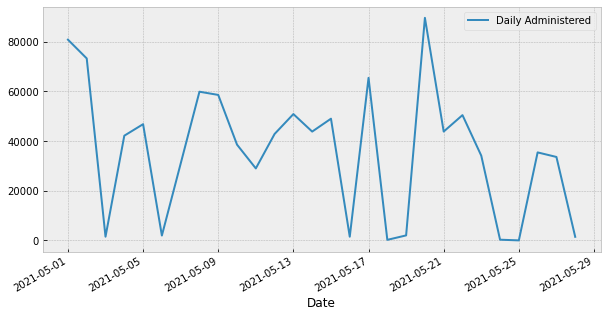

In [8]:
georgia_may.plot()

# AR(3)

In [9]:
preds_3, mse, mape = AR(georgia_may.copy(), 3)
print("MSE:{}\nMAPE:{}".format(mse, mape))

MSE:1273507395.7608464
MAPE:inf


# AR(5)

In [10]:
preds_5, mse, mape = AR(georgia_may.copy(), 5)
print("MSE:{}\nMAPE:{}".format(mse, mape))

MSE:1217949112.4454513
MAPE:inf


In [11]:
test_data = georgia_may.loc[test_start_date:]
test_data["Predicted:AR(3)"] = preds_3
test_data["Predicted:AR(5)"] = preds_5
test_data

,Daily Administered,Predicted:AR(3),Predicted:AR(5)
Date,,,
2021-05-22,50463.0,6748.680788,24393.722503
2021-05-23,34122.0,36174.959561,52204.140957
2021-05-24,277.0,34104.000860,22643.618767
2021-05-25,0.0,56778.018657,38875.489667
2021-05-26,35444.0,70019.623264,66651.335541
2021-05-27,33609.0,50574.097076,60167.756507
2021-05-28,1434.0,35317.591760,63306.757055


<AxesSubplot:xlabel='Date'>

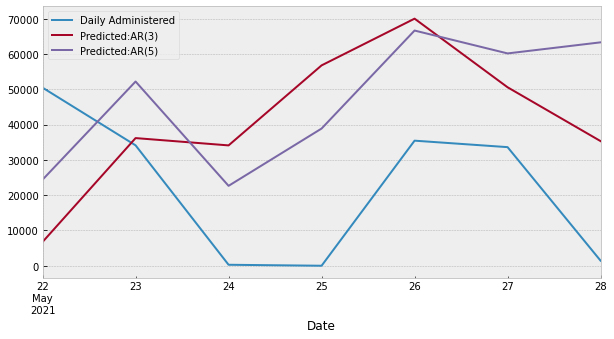

In [12]:
test_data.plot()

# EWMA

# $\alpha$ = 0.5

In [13]:
preds_p5, mse, mape = EWMA(georgia_may.copy()["Daily Administered"], 0.5)
print("MSE:{}\nMAPE:{}".format(mse, mape))

MSE:956346481.6539252
MAPE:inf


# $\alpha$ = 0.8

In [14]:
preds_p8, mse, mape = EWMA(georgia_may.copy()["Daily Administered"], 0.8)
print("MSE:{}\nMAPE:{}".format(mse, mape))

MSE:1169488990.656236
MAPE:inf


In [15]:
test_data = georgia_may.loc[test_start_date:]
test_data["Predicted:EWMA(0.5)"] = preds_p5[-7:]
test_data["Predicted:EWMA(0.8)"] = preds_p8[-7:]
test_data

,Daily Administered,Predicted:EWMA(0.5),Predicted:EWMA(0.8)
Date,,,
2021-05-22,50463.0,47399.468256,49570.872674
2021-05-23,34122.0,48931.234128,50284.574535
2021-05-24,277.0,41526.617064,37354.514907
2021-05-25,0.0,20901.808532,7692.502981
2021-05-26,35444.0,10450.904266,1538.500596
2021-05-27,33609.0,22947.452133,28662.900119
2021-05-28,1434.0,28278.226066,32619.780024


<AxesSubplot:xlabel='Date'>

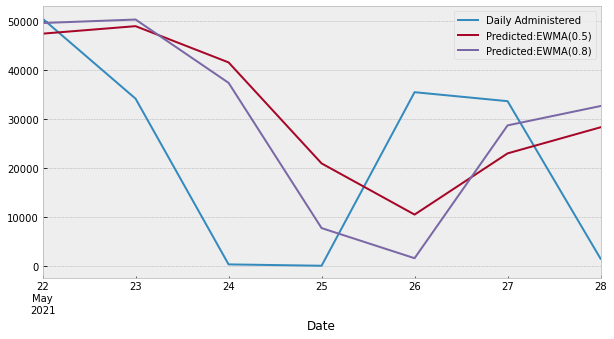

In [16]:
test_data.plot()

# Indiana

In [17]:
indiana_vaccines = pd.read_csv("indiana_vaccinations.csv")
indiana_vaccines["Date"] = pd.to_datetime(indiana_vaccines["Date"])
indiana_vaccines = indiana_vaccines.sort_values(by = "Date").set_index("Date")

In [18]:
indiana_may = indiana_vaccines.loc[start_date:end_date][['Daily Administered']]

<AxesSubplot:xlabel='Date'>

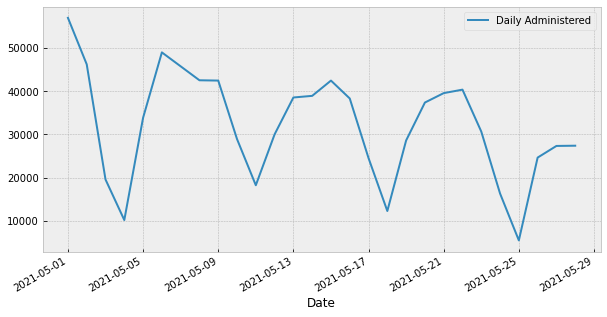

In [19]:
indiana_may.plot()

# AR(3)

In [20]:
preds_3, mse, mape = AR(indiana_may.copy(), 3)
print("MSE:{}\nMAPE:{}".format(mse, mape))

MSE:138610049.2708631
MAPE:77.20496686304068


# AR(5)

In [21]:
preds_5, mse, mape = AR(indiana_may.copy(), 5)
print("MSE:{}\nMAPE:{}".format(mse, mape))

MSE:171446604.5410115
MAPE:80.5978322366637


In [22]:
test_data = indiana_may.loc[test_start_date:]
test_data["Predicted:AR(3)"] = preds_3
test_data["Predicted:AR(5)"] = preds_5
test_data

,Daily Administered,Predicted:AR(3),Predicted:AR(5)
Date,,,
2021-05-22,40370.0,35122.711302,44961.861234
2021-05-23,30675.0,32962.308384,33584.023201
2021-05-24,16346.0,26818.083516,24059.305337
2021-05-25,5506.0,23959.265482,24539.020670
2021-05-26,24657.0,27232.342761,28305.421742
2021-05-27,27350.0,45967.779235,50718.376818
2021-05-28,27405.0,38983.553124,41168.562579


<AxesSubplot:xlabel='Date'>

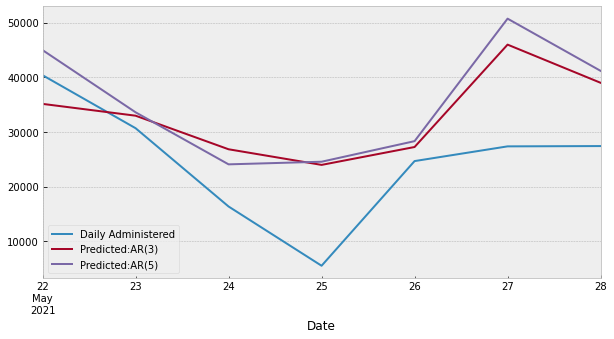

In [23]:
test_data.plot()

# EWMA

# $\alpha$ = 0.5

In [24]:
preds_p5, mse, mape = EWMA(indiana_may.copy()["Daily Administered"], 0.5)
print("MSE:{}\nMAPE:{}".format(mse, mape))

MSE:176321374.69042543
MAPE:59.39813552165008


# $\alpha$ = 0.8

In [25]:
preds_p8, mse, mape = EWMA(indiana_may.copy()["Daily Administered"], 0.8)
print("MSE:{}\nMAPE:{}".format(mse, mape))

MSE:155019486.29836497
MAPE:51.13497840349774


In [26]:
test_data = indiana_may.loc[test_start_date:]
test_data["Predicted:EWMA(0.5)"] = preds_p5[-7:]
test_data["Predicted:EWMA(0.8)"] = preds_p8[-7:]
test_data

,Daily Administered,Predicted:EWMA(0.5),Predicted:EWMA(0.8)
Date,,,
2021-05-22,40370.0,35455.498657,38672.624945
2021-05-23,30675.0,37912.749329,40030.524989
2021-05-24,16346.0,34293.874664,32546.104998
2021-05-25,5506.0,25319.937332,19586.021000
2021-05-26,24657.0,15412.968666,8322.004200
2021-05-27,27350.0,20034.984333,21390.000840
2021-05-28,27405.0,23692.492167,26158.000168


<AxesSubplot:xlabel='Date'>

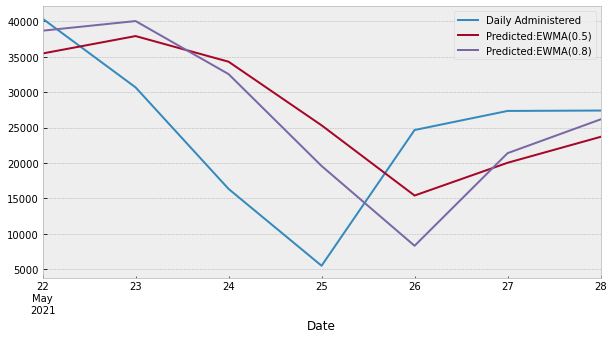

In [27]:
test_data.plot()